In [40]:
%matplotlib inline

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets

# Intuition behind triplet network

In this notebook I will try out [triplet network](https://arxiv.org/abs/1412.6622) on simple datasets to get a glimpse into inner machanics. There is a repo for [MNIST](https://github.com/andreasveit/triplet-network-pytorch) for further exploration.

## IRIS dataset

In [123]:
iris = datasets.load_iris()
data_tensor = torch.tensor(iris['data'], dtype=torch.float32)

In [128]:
class Tripletnet(nn.Module):
    def __init__(self, embeddingnet):
        super(Tripletnet, self).__init__()
        self.embeddingnet = embeddingnet

    def forward(self, x, y, z):
        embedded_x = self.embeddingnet(x)
        embedded_y = self.embeddingnet(y)
        embedded_z = self.embeddingnet(z)
        dist_a = F.pairwise_distance(embedded_x, embedded_y, 2)
        dist_b = F.pairwise_distance(embedded_x, embedded_z, 2)
        return dist_a, dist_b, embedded_x, embedded_y, embedded_z
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 8)
        self.fc2 = nn.Linear(8, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.4)
        return self.fc2(x)

model = Net()
tnet = Tripletnet(model)

optimizer = optim.SGD(tnet.parameters(), lr=0.01)
criterion = torch.nn.MarginRankingLoss(margin = 0.2)

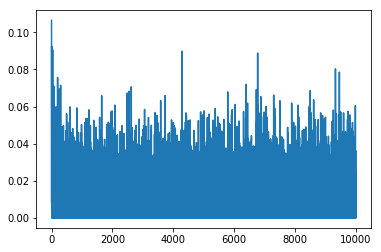

In [129]:
L = []
n = 25

for _ in range(10000):
    x_class = np.random.randint(3)
    x_main, x_plus = np.random.choice(np.arange(150)[iris['target'] == x_class], size=(2, n), replace=False)
    x_minus = np.random.choice(np.arange(150)[iris['target'] != x_class], size=n, replace=False)
    
    dista, distb, embedded_x, embedded_y, embedded_z = tnet(data_tensor[x_main], data_tensor[x_minus], data_tensor[x_plus])
    
    target = torch.FloatTensor(dista.size()).fill_(1)

    loss_triplet = criterion(dista, distb, target)
    # loss_embedd = embedded_x.norm(2) + embedded_y.norm(2) + embedded_z.norm(2)
    loss = loss_triplet # + 0.001 * loss_embedd
    L.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(L)

In [130]:
embedding = model(data_tensor).detach().numpy()

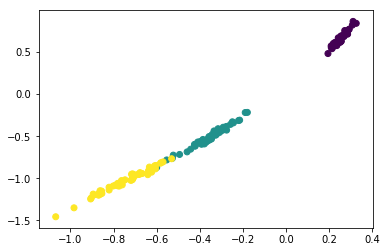

In [131]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=iris['target'])

## Encircled point cloud

For comments see git repo readme.

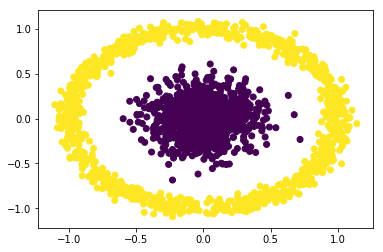

In [35]:
inner = np.random.normal(size=(1000, 2)) / 5
outer = np.random.uniform(size=(1000)) * 2 * np.pi
outer = np.array(list(map(lambda x: [np.cos(x) + np.random.normal() * 0.05,
                                     np.sin(x) + np.random.normal() * 0.05], outer)))
data = np.vstack([inner, outer])
data_tensor = torch.tensor(data, dtype=torch.float32)
c = np.hstack([np.zeros(1000), np.ones(1000)])

plt.scatter(data[:, 0], data[:, 1], c=c)

In [36]:
class Tripletnet(nn.Module):
    def __init__(self, embeddingnet):
        super(Tripletnet, self).__init__()
        self.embeddingnet = embeddingnet

    def forward(self, x, y, z):
        embedded_x = self.embeddingnet(x)
        embedded_y = self.embeddingnet(y)
        embedded_z = self.embeddingnet(z)
        dist_a = F.pairwise_distance(embedded_x, embedded_y, 2)
        dist_b = F.pairwise_distance(embedded_x, embedded_z, 2)
        return dist_a, dist_b, embedded_x, embedded_y, embedded_z
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 8)
        self.fc2 = nn.Linear(8, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.4)
        return self.fc2(x)

# def init_weights(m):
#     if type(m) == nn.Linear:
#         torch.nn.init.xavier_normal(m.weight)
#         m.bias.data.fill_(0.)

model = Net()
# model.apply(init_weights)
tnet = Tripletnet(model)

optimizer = optim.SGD(tnet.parameters(), lr=0.01)
criterion = torch.nn.MarginRankingLoss(margin = 0.2)

In [37]:
L = []
n = 50

for i in range(5000):
    if i % 100 == 0:
        embedding = model(data_tensor).detach().numpy()
        plt.scatter(embedding[:, 0], embedding[:, 1], c=c)
        plt.axis('off')
        plt.savefig('{0}.jpg'.format(i))
        plt.close()

    x_class = np.random.randint(2)
    x_main, x_plus = np.random.choice(np.arange(2000)[c == x_class], size=(2, n), replace=False)
    x_minus = np.random.choice(np.arange(2000)[c != x_class], size=n, replace=False)
    
    dista, distb, embedded_x, embedded_y, embedded_z = tnet(data_tensor[x_main], data_tensor[x_minus], data_tensor[x_plus])
    
    target = torch.FloatTensor(dista.size()).fill_(1)

    loss = criterion(dista, distb, target)
    L.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# plt.plot(L)

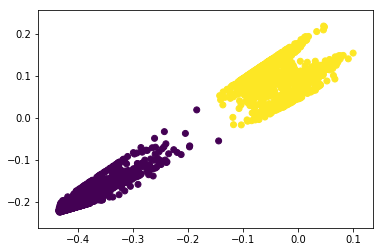

In [38]:
embedding = model(data_tensor).detach().numpy()
plt.scatter(embedding[:, 0], embedding[:, 1], c=c)